In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

This is a template for your final project. 

In [27]:
df = pd.read_csv('work/hse/mda_machine_learning/final/IMDb movies.csv')

df.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


### Part 1.

Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

I select average_votes.

Originally I thought to use income to analyse features for a film to be commercially successful. But the proportion of missing incomes are too substantial to run analysis, < 20%.

We try to establish models with data that have more than 50% of valid data.

In [28]:
df = df.loc[:,df.columns[(df.count() / df.shape[0]) > 0.5]]

1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

It's a regression

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

We use R2 score

### Part 2.

Explore and preprocess the data

2.2 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformatios. 


Dropping some irrelavent columns

In [29]:
df.drop(['imdb_title_id', 'title', 'original_title', 'year', 'date_published', 'description'], axis=1, inplace=True)

In [30]:
df.dtypes

genre                    object
duration                  int64
country                  object
language                 object
director                 object
writer                   object
production_company       object
actors                   object
avg_vote                float64
votes                     int64
reviews_from_users      float64
reviews_from_critics    float64
dtype: object

In [31]:
actor_arr = df.actors.str.split(',').ravel()
actor_count = {}
for actors in actor_arr:
    if type(actors) is float:
        continue
            
    for a in actors:
        a = a.strip()
        if a not in actor_count:
            actor_count[a] = 0
        
        actor_count[a] += 1

actor_count = pd.DataFrame({'actor': actor_count.keys(), 'count': actor_count.values()})

In [32]:
hot_actors = actor_count[actor_count['count'] > 17].actor.values
hot_actors

array(['Emil Jannings', 'Torben Meyer', 'Edmund Breon', ...,
       'Juno Temple', 'Bill Hader', 'Kangana Ranaut'], dtype=object)

In [33]:
def count_hot(ar):
    c = 0
    if type(ar) is not str:
        return c

    for a in ar.split(','):
        if a.strip() in hot_actors:
            c += 1
    
    return c

In [34]:
df['hot_actor'] = df.actors.apply(count_hot)
df['hot_actor'].describe()

count    60198.000000
mean         3.482126
std          3.171783
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         15.000000
Name: hot_actor, dtype: float64

In [35]:
df.nunique()

genre                    1202
duration                  257
country                  3318
language                 3192
director                22771
writer                  47546
production_company      21441
actors                  60145
avg_vote                   89
votes                   12647
reviews_from_users       1042
reviews_from_critics      529
hot_actor                  16
dtype: int64

In [36]:
df['duration'].corr(df['avg_vote'])

0.23167034212956755

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

cate_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
numeric_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

# Combine all three pipelines in one column transformer
column_transformer = ColumnTransformer([
 ('numeric', numeric_pipe, ['duration', 'hot_actor', 'reviews_from_users', 'reviews_from_critics']),
 ],
remainder='drop')

2.1 Split data into train and test

In [38]:
from sklearn.model_selection import train_test_split

tr, te = train_test_split(df, test_size=0.2, random_state=42)

y_train = tr['avg_vote']
y_test = te['avg_vote']
X_train = tr.drop(['avg_vote'], axis=1)
X_test = te.drop(['avg_vote'], axis=1)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr_reg_pipe = Pipeline([
    ('col_trans', column_transformer),
    ('lr', LinearRegression())
])

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

In [40]:
lr_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'hot_actor',
                                                   'reviews_from_users',
                                                   'reviews_from_critics'])])),
                ('lr', LinearRegression())])

3.2 Use cross-validation to compare models and select best set of hyperparameters

In [41]:
y_hat = lr_reg_pipe.predict(X_test)

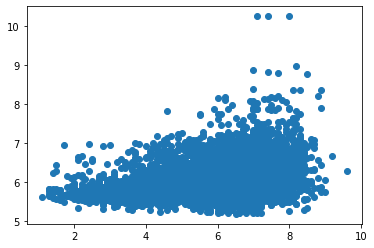

In [42]:
plt.scatter(y_test, y_hat)

In [43]:
np.corrcoef(y_hat, y_test)

array([[1.        , 0.30276435],
       [0.30276435, 1.        ]])

In [44]:
from sklearn.metrics import r2_score

In [45]:
r2_score(y_test, y_hat)

0.09163353607473745

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?